<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 1591, '日付': '2021-01-06T08:00:00.000Z'},
 {'小計': 2447, '日付': '2021-01-07T08:00:00.000Z'},
 {'小計': 2392, '日付': '2021-01-08T08:00:00.000Z'},
 {'小計': 2268, '日付': '2021-01-09T08:00:00.000Z'},
 {'小計': 1494, '日付': '2021-01-10T08:00:00.000Z'},
 {'小計': 1219, '日付': '2021-01-11T08:00:00.000Z'},
 {'小計': 970, '日付': '2021-01-12T08:00:00.000Z'},
 {'小計': 1433, '日付': '2021-01-13T08:00:00.000Z'},
 {'小計': 1502, '日付': '2021-01-14T08:00:00.000Z'},
 {'小計': 2001, '日付': '2021-01-15T08:00:00.000Z'},
 {'小計': 1809, '日付': '2021-01-16T08:00:00.000Z'},
 {'小計': 1592, '日付': '2021-01-17T08:00:00.000Z'},
 {'小計': 1204, '日付': '2021-01-18T08:00:00.000Z'},
 {'小計': 1240, '日付': '2021-01-19T08:00:00.000Z'},
 {'小計': 1274, '日付': '2021-01-20T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-01-16 17:00:00+09:00,1111,0,1809,2021-01-16 17:00:00+09:00
2021-01-17 17:00:00+09:00,759,0,1592,2021-01-17 17:00:00+09:00
2021-01-18 17:00:00+09:00,917,0,1204,2021-01-18 17:00:00+09:00
2021-01-19 17:00:00+09:00,633,0,1240,2021-01-19 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-01-16 17:00:00+09:00,1111,0,1809,2021-01-16 17:00:00+09:00,1109.142857,7764.0,0.0,0.0,1489.714286,10428.0
2021-01-17 17:00:00+09:00,759,0,1592,2021-01-17 17:00:00+09:00,1021.285714,7149.0,0.0,0.0,1503.714286,10526.0
2021-01-18 17:00:00+09:00,917,0,1204,2021-01-18 17:00:00+09:00,969.714286,6788.0,0.0,0.0,1501.571429,10511.0
2021-01-19 17:00:00+09:00,633,0,1240,2021-01-19 17:00:00+09:00,885.000000,6195.0,0.0,0.0,1540.142857,10781.0
2021-01-20 17:00:00+09:00,0,0,1274,2021-01-20 17:00:00+09:00,752.000000,5264.0,0.0,0.0,1517.428571,10622.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-01-06 17:00:00+09:00,1326,0,1591,2021-01-06 17:00:00+09:00,1160.428571,8123.0,0.0,0.0,1071.857143,7503.0,'21w01,Wed
2021-01-07 17:00:00+09:00,1493,0,2447,2021-01-07 17:00:00+09:00,1202.857143,8420.0,0.0,0.0,1230.428571,8613.0,'21w01,Thu
2021-01-08 17:00:00+09:00,1350,0,2392,2021-01-08 17:00:00+09:00,1260.285714,8822.0,0.0,0.0,1460.285714,10222.0,'21w01,Fri
2021-01-09 17:00:00+09:00,1680,0,2268,2021-01-09 17:00:00+09:00,1336.571429,9356.0,0.0,0.0,1668.000000,11676.0,'21w01,Sat
2021-01-10 17:00:00+09:00,1374,0,1494,2021-01-10 17:00:00+09:00,1377.000000,9639.0,0.0,0.0,1764.857143,12354.0,'21w01,Sun
2021-01-11 17:00:00+09:00,1278,0,1219,2021-01-11 17:00:00+09:00,1392.142857,9745.0,0.0,0.0,1812.714286,12689.0,'21w02,Mon
2021-01-12 17:00:00+09:00,1226,0,970,2021-01-12 17:00:00+09:00,1389.571429,9727.0,0.0,0.0,1768.714286,12381.0,'21w02,Tue
2021-01-13 17:00:00+09:00,931,0,1433,2021-01-13 17:00:00+09:00,1333.142857,9332.0,0.0,0.0,1746.142857,12223.0,'21w02,Wed
2021-01-14 17:00:00+09:00,913,0,1502,2021-01-14 17:00:00+09:00,1250.285714,8752.0,0.0,0.0,1611.142857,11278.0,'21w02,Thu
2021-01-15 17:00:00+09:00,931,0,2001,2021-01-15 17:00:00+09:00,1190.428571,8333.0,0.0,0.0,1555.285714,10887.0,'21w02,Fri


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-12-31 17:00:00+09:00,904.500000,3618
2021-01-10 17:00:00+09:00,1764.857143,12354
2021-01-17 17:00:00+09:00,1503.714286,10526
2021-01-20 17:00:00+09:00,1239.333333,3718
2021-01-03 17:00:00+09:00,804.333333,2413


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-01-06 17:00:00+09:00,1326,0,1591,2021-01-06 17:00:00+09:00,1160.428571,8123.0,0.0,0.0,1071.857143,7503.0,'21w01,Wed,NaN,NaN
2021-01-07 17:00:00+09:00,1493,0,2447,2021-01-07 17:00:00+09:00,1202.857143,8420.0,0.0,0.0,1230.428571,8613.0,'21w01,Thu,NaN,NaN
2021-01-08 17:00:00+09:00,1350,0,2392,2021-01-08 17:00:00+09:00,1260.285714,8822.0,0.0,0.0,1460.285714,10222.0,'21w01,Fri,NaN,NaN
2021-01-09 17:00:00+09:00,1680,0,2268,2021-01-09 17:00:00+09:00,1336.571429,9356.0,0.0,0.0,1668.000000,11676.0,'21w01,Sat,NaN,NaN
2021-01-10 17:00:00+09:00,1374,0,1494,2021-01-10 17:00:00+09:00,1377.000000,9639.0,0.0,0.0,1764.857143,12354.0,'21w01,Sun,1764.857143,12354.0
2021-01-11 17:00:00+09:00,1278,0,1219,2021-01-11 17:00:00+09:00,1392.142857,9745.0,0.0,0.0,1812.714286,12689.0,'21w02,Mon,NaN,NaN
2021-01-12 17:00:00+09:00,1226,0,970,2021-01-12 17:00:00+09:00,1389.571429,9727.0,0.0,0.0,1768.714286,12381.0,'21w02,Tue,NaN,NaN
2021-01-13 17:00:00+09:00,931,0,1433,2021-01-13 17:00:00+09:00,1333.142857,9332.0,0.0,0.0,1746.142857,12223.0,'21w02,Wed,NaN,NaN
2021-01-14 17:00:00+09:00,913,0,1502,2021-01-14 17:00:00+09:00,1250.285714,8752.0,0.0,0.0,1611.142857,11278.0,'21w02,Thu,NaN,NaN
2021-01-15 17:00:00+09:00,931,0,2001,2021-01-15 17:00:00+09:00,1190.428571,8333.0,0.0,0.0,1555.285714,10887.0,'21w02,Fri,NaN,NaN


### グラフ出力

In [12]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [13]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

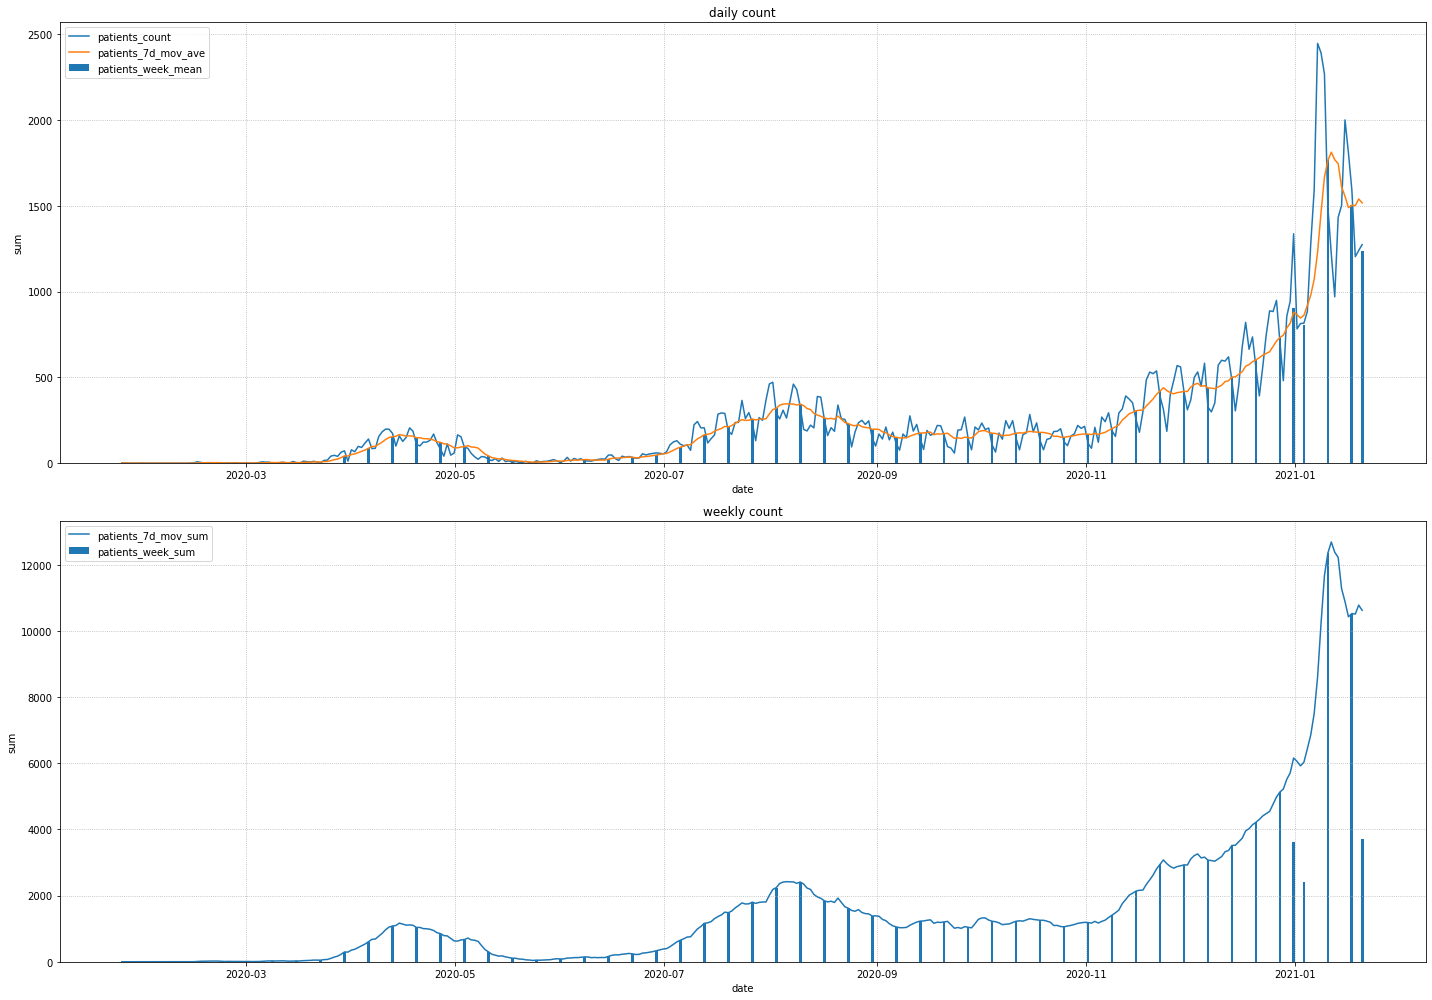

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [15]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [16]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [17]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [18]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [19]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
348,1.609920e+09,2021,1,6,0,0,0,0,0,0,1,348,0,274,1326,1160.428571,8123.0,0,0.0,0.0,1591,1071.857143,7503.0
349,1.610006e+09,2021,1,7,0,0,0,0,1,0,0,349,0,275,1493,1202.857143,8420.0,0,0.0,0.0,2447,1230.428571,8613.0
350,1.610093e+09,2021,1,8,1,0,0,0,0,0,0,350,0,276,1350,1260.285714,8822.0,0,0.0,0.0,2392,1460.285714,10222.0
351,1.610179e+09,2021,1,9,0,0,1,0,0,0,0,351,0,277,1680,1336.571429,9356.0,0,0.0,0.0,2268,1668.000000,11676.0
352,1.610266e+09,2021,1,10,0,0,0,1,0,0,0,352,0,278,1374,1377.000000,9639.0,0,0.0,0.0,1494,1764.857143,12354.0
353,1.610352e+09,2021,1,11,0,1,0,0,0,0,0,353,0,279,1278,1392.142857,9745.0,0,0.0,0.0,1219,1812.714286,12689.0
354,1.610438e+09,2021,1,12,0,0,0,0,0,1,0,354,0,280,1226,1389.571429,9727.0,0,0.0,0.0,970,1768.714286,12381.0
355,1.610525e+09,2021,1,13,0,0,0,0,0,0,1,355,0,281,931,1333.142857,9332.0,0,0.0,0.0,1433,1746.142857,12223.0
356,1.610611e+09,2021,1,14,0,0,0,0,1,0,0,356,0,282,913,1250.285714,8752.0,0,0.0,0.0,1502,1611.142857,11278.0
357,1.610698e+09,2021,1,15,1,0,0,0,0,0,0,357,0,283,931,1190.428571,8333.0,0,0.0,0.0,2001,1555.285714,10887.0


In [20]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            363 non-null    float64
 1   year                 363 non-null    int64  
 2   month                363 non-null    int64  
 3   day                  363 non-null    int64  
 4   Fri                  363 non-null    uint8  
 5   Mon                  363 non-null    uint8  
 6   Sat                  363 non-null    uint8  
 7   Sun                  363 non-null    uint8  
 8   Thu                  363 non-null    uint8  
 9   Tue                  363 non-null    uint8  
 10  Wed                  363 non-null    uint8  
 11  passed               363 non-null    int64  
 12  emergency            363 non-null    int64  
 13  em_passed            363 non-null    int64  
 14  contacts_count       363 non-null    int64  
 15  contacts_7d_mov_ave  363 non-null    flo

In [21]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.630000e+02,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,1.595491e+09,2020.055096,6.559229,15.705234,0.143251,0.143251,0.143251,0.143251,0.140496,0.143251,0.143251,181.000000,0.134986,114.644628,767.391185,762.566640,5337.955923,1015.203857,1015.203857,7106.426997,245.696970,234.268910,1639.837466
std,9.066238e+06,0.228483,3.433454,8.841367,0.350812,0.350812,0.350812,0.350812,0.347980,0.350812,0.350812,104.933312,0.342181,94.505008,465.712750,451.760662,3162.342424,872.321905,745.911288,5221.379013,368.626421,333.606642,2335.278042
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.587672e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.500000,0.000000,16.500000,456.500000,459.642857,3217.500000,0.000000,4.857143,34.000000,22.500000,21.000000,147.000000
50%,1.595491e+09,2020.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181.000000,0.000000,107.000000,613.000000,620.142857,4341.000000,1044.000000,1066.285714,7464.000000,144.000000,157.285714,1101.000000
75%,1.603310e+09,2020.000000,10.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,271.500000,0.000000,197.500000,953.500000,970.928571,6796.500000,1638.000000,1567.000000,10969.000000,267.500000,258.214286,1807.500000
max,1.611130e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,362.000000,1.000000,288.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2447.000000,1812.714286,12689.000000


In [22]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.395201,0.687043,-0.013360,-0.009755,0.001951,-0.005853,-0.001951,3.261892e-18,0.005853,0.009755,1.000000e+00,-0.312894,0.989241,-0.023483,0.005778,0.005783,-0.242501,-0.244579,-0.244579,0.666876,0.697838,0.697862
year,3.952007e-01,1.000000,-0.391517,-0.142360,0.004652,0.004652,0.004652,0.004652,-2.813992e-02,0.004652,0.004652,3.952007e-01,-0.095390,0.419250,0.160313,0.217839,0.217838,-0.281413,-0.329104,-0.329104,0.790341,0.834574,0.834567
month,6.870429e-01,-0.391517,1.000000,0.016001,-0.013944,-0.002477,-0.009357,-0.004770,2.191712e-02,0.002110,0.006697,6.870429e-01,-0.236074,0.656507,-0.148004,-0.164527,-0.164521,-0.018009,0.019916,0.019916,0.040565,0.035692,0.035723
day,-1.336025e-02,-0.142360,0.016001,1.000000,0.005636,0.008308,-0.003271,-0.010396,7.212704e-03,0.000292,-0.007724,-1.336025e-02,-0.000508,-0.011648,-0.022430,-0.022641,-0.022646,0.016878,-0.002917,-0.002917,-0.050724,-0.044644,-0.044664
Fri,-9.755446e-03,0.004652,-0.013944,0.005636,1.000000,-0.167203,-0.167203,-0.167203,-1.653215e-01,-0.167203,-0.167203,-9.755446e-03,-0.000444,-0.008209,-0.021243,-0.006054,-0.006053,0.047946,-0.001531,-0.001531,0.047567,-0.010787,-0.010799
Mon,1.951089e-03,0.004652,-0.002477,0.008308,-0.167203,1.000000,-0.167203,-0.167203,-1.653215e-01,-0.167203,-0.167203,1.951089e-03,-0.000444,0.002040,0.043601,0.000886,0.000887,0.193442,-0.001531,-0.001531,-0.092308,0.004726,0.004729
Sat,-5.853268e-03,0.004652,-0.009357,-0.003271,-0.167203,-0.167203,1.000000,-0.167203,-1.653215e-01,-0.167203,-0.167203,-5.853268e-03,-0.000444,-0.004793,0.051548,-0.003288,-0.003286,-0.226112,-0.001531,-0.001531,0.054296,-0.004690,-0.004699
Sun,-1.951089e-03,0.004652,-0.004770,-0.010396,-0.167203,-0.167203,-0.167203,1.000000,-1.653215e-01,-0.167203,-0.167203,-1.951089e-03,-0.000444,-0.001377,-0.014851,-0.001398,-0.001396,-0.208428,-0.001531,-0.001531,-0.031748,0.000670,0.000669
Thu,3.261892e-18,-0.028140,0.021917,0.007213,-0.165321,-0.165321,-0.165321,-0.165321,1.000000e+00,-0.165321,-0.165321,-8.063150e-19,0.002684,-0.002090,-0.005539,0.004960,0.004961,0.065201,0.009261,0.009261,0.058263,-0.012122,-0.012114
Tue,5.853268e-03,0.004652,0.002110,0.000292,-0.167203,-0.167203,-0.167203,-0.167203,-1.653215e-01,1.000000,-0.167203,5.853268e-03,-0.000444,0.005456,-0.026518,0.002462,0.002463,0.076390,-0.001531,-0.001531,-0.037260,0.008905,0.008910


---

In [23]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [24]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,1.610784e+09,0,0,1,0,0,0,0,358,0,284,1111,0,1809,1489.714286,10428.0
359,1.610870e+09,0,0,0,1,0,0,0,359,0,285,759,0,1592,1503.714286,10526.0
360,1.610957e+09,0,1,0,0,0,0,0,360,0,286,917,0,1204,1501.571429,10511.0
361,1.611043e+09,0,0,0,0,0,1,0,361,0,287,633,0,1240,1540.142857,10781.0


In [25]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
358,1.610784e+09,358,0,1809,1489.714286,10428.0
359,1.610870e+09,359,0,1592,1503.714286,10526.0
360,1.610957e+09,360,0,1204,1501.571429,10511.0
361,1.611043e+09,361,0,1240,1540.142857,10781.0


In [26]:
import seaborn as sns

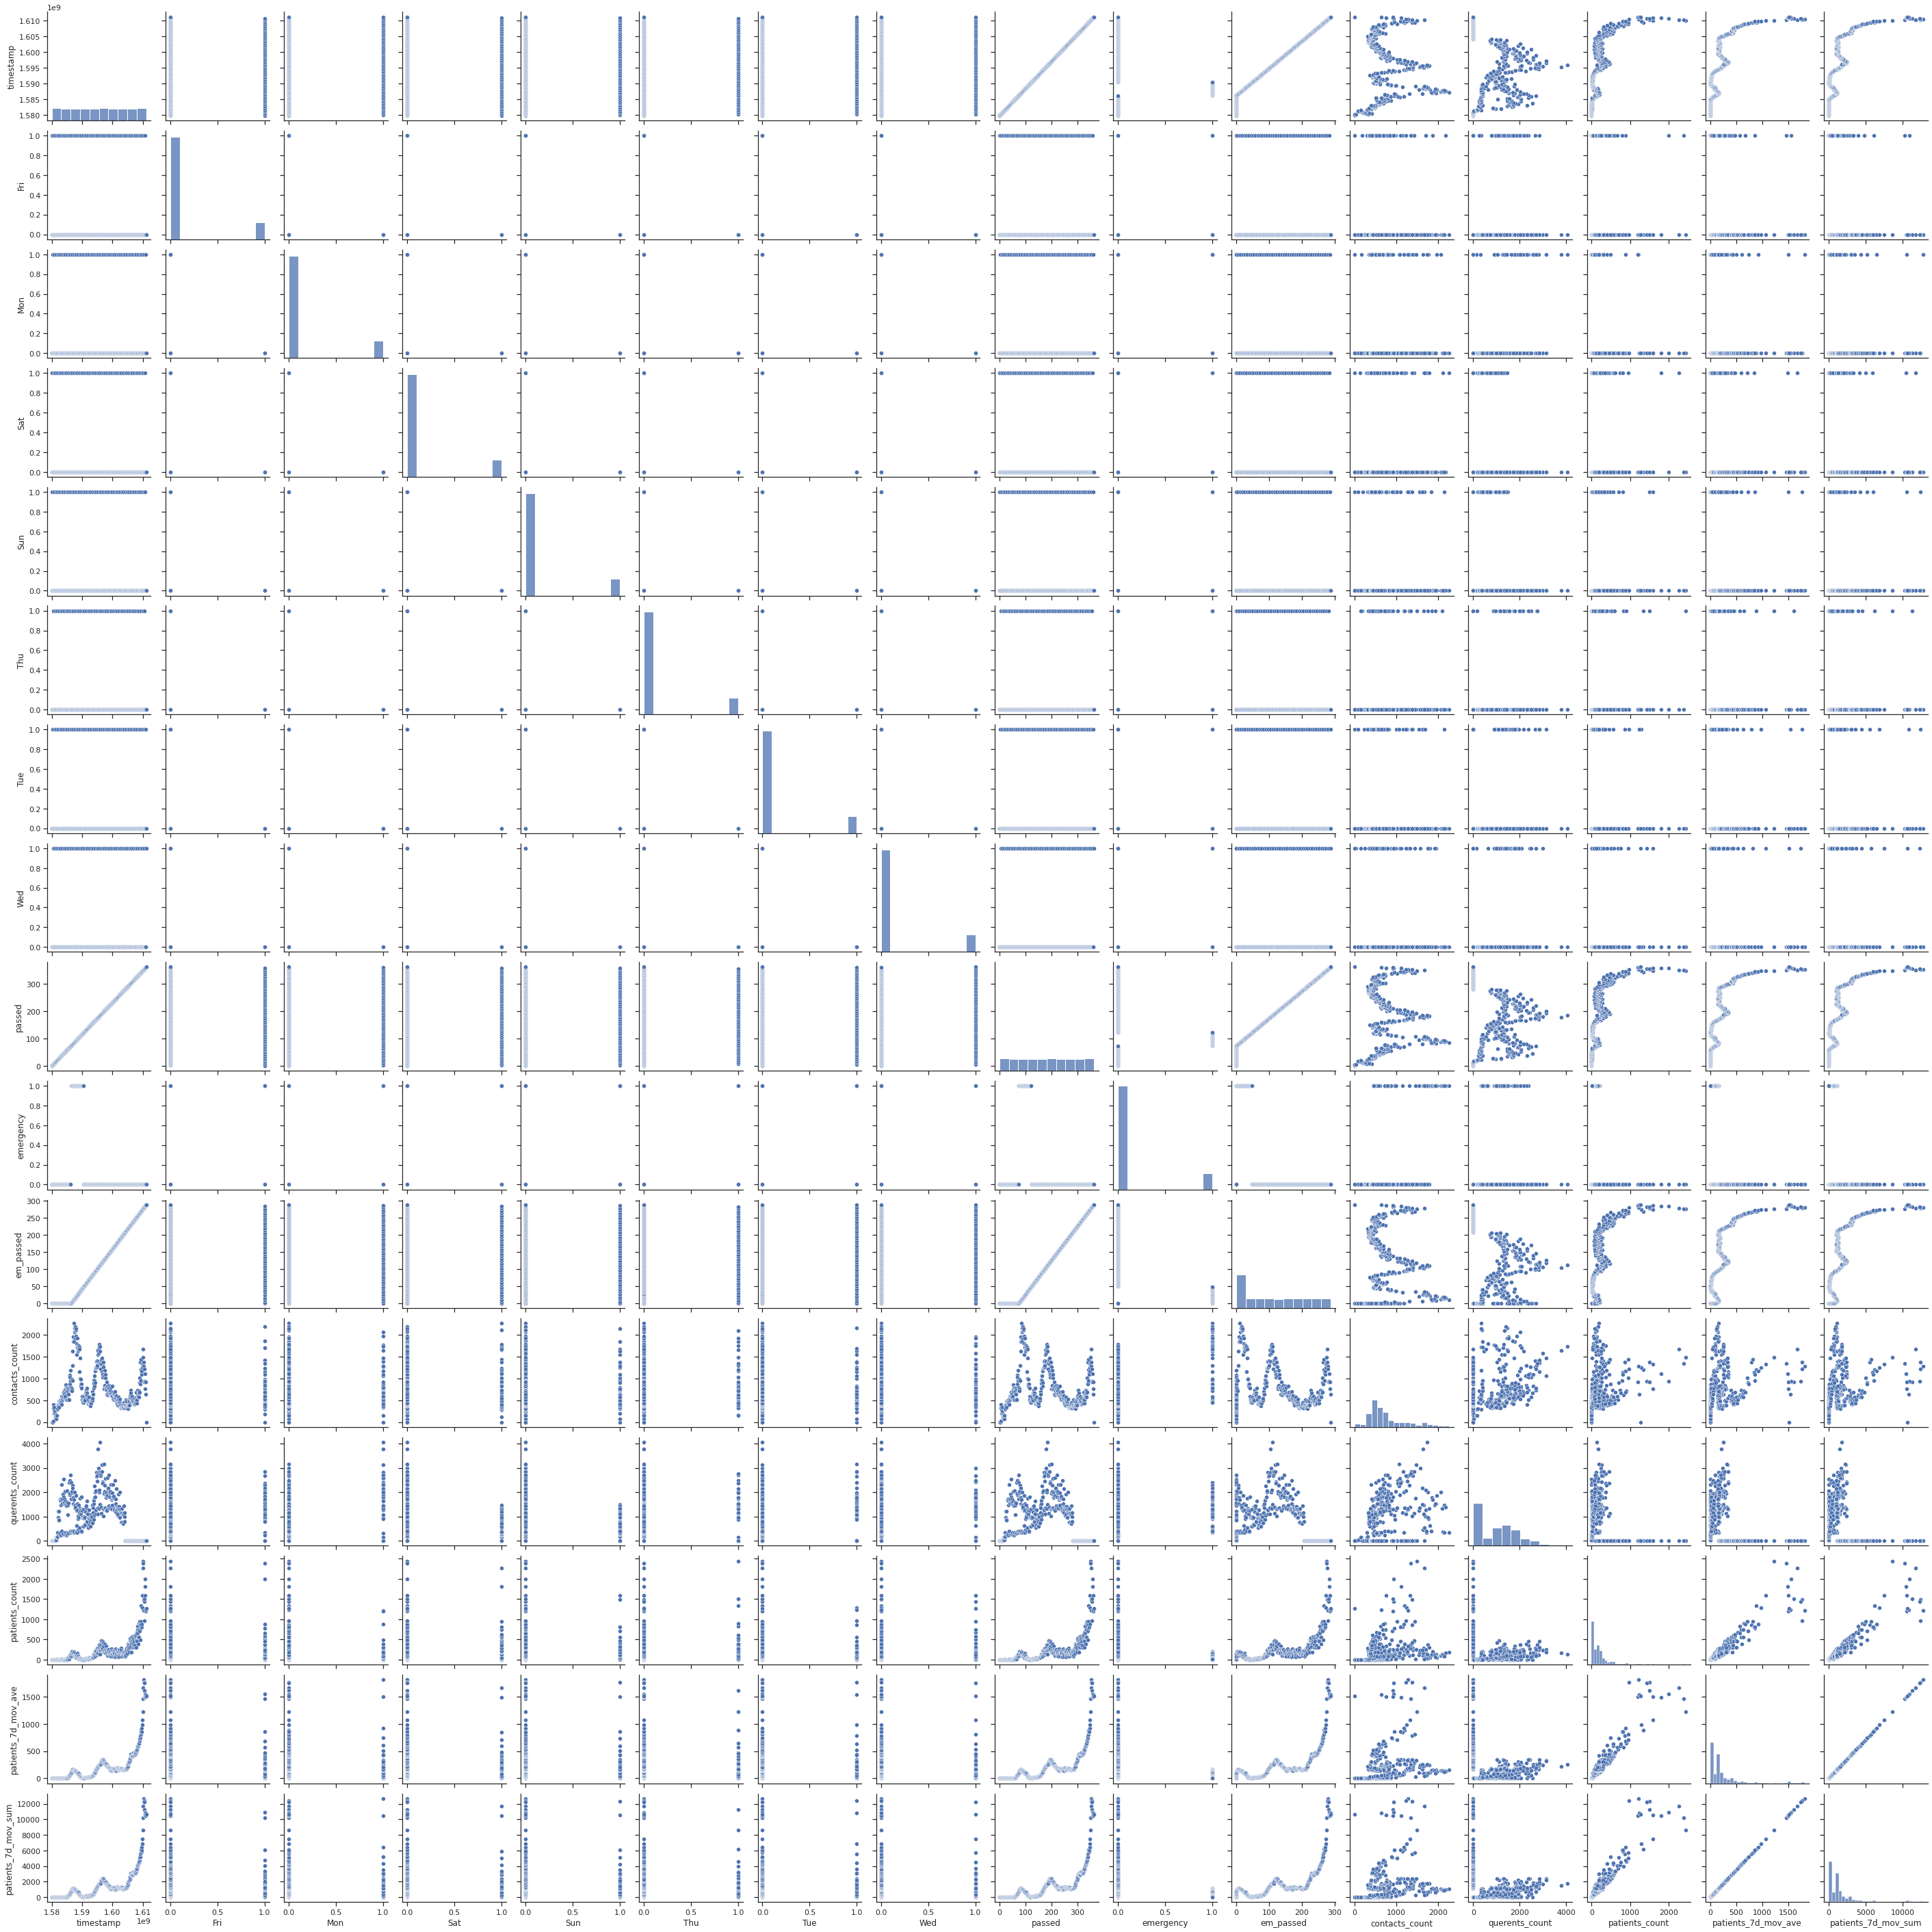

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

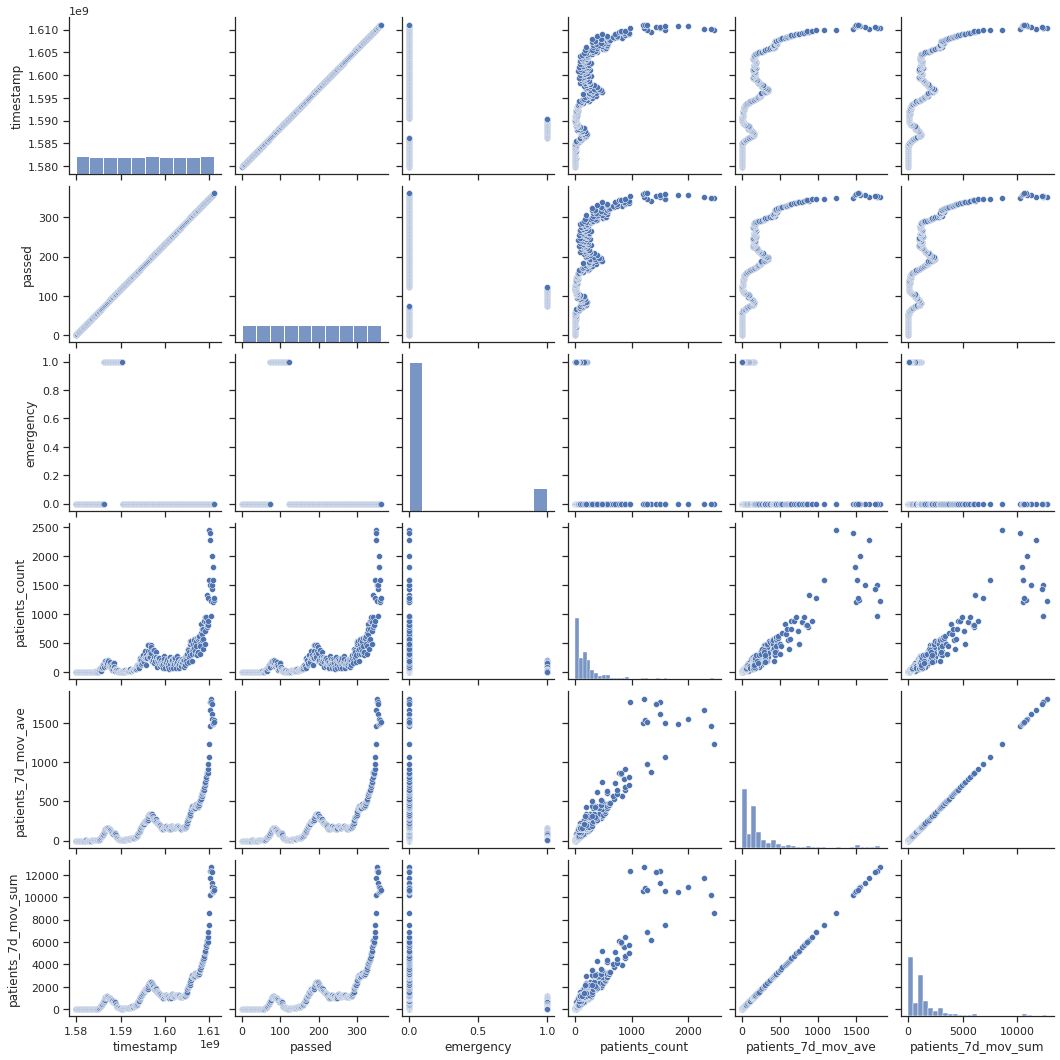

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.6.9
